# The transfer study

## Init

In [1]:
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import gymnasium as gym
from sb3_contrib import TQC
from huggingface_sb3 import load_from_hub

from matplotlib import pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

from pipoli.core import DimensionalPolicy, Dimension, Context, Policy
from pipoli.sources.sb3 import SB3Policy
from pipoli.evaluation import linsweep_change_contexts, linsweep_scale_contexts, scale_sweep_volume_bounds, record_sweep

from make_cheetah import make_cheetah, make_cheetah_xml

In [2]:
ROOT = Path() / "output"
XML_FILES = ROOT / "xml_files"
DATA = ROOT / "data"

In [3]:
class NaiveObsScaledActPolicy(Policy):

    def __init__(self, dim_pol, context, base):
        self.dim_pol = dim_pol
        self.context = context
        self.base = base
        act_dims = dim_pol.act_dims
        self.orig_to_adim, _ = dim_pol.context.make_transforms(act_dims, base)
        _, self.adim_to_scale = context.make_transforms(act_dims, base)
    
    def action(self, obs):
        """Scale only the action from a naive observation.
        
        Usually, the actuators of a system are sized accordingly. It would be
        unfair to not allow the policy to use the full range or allow it to use to much.
        """
        orig_act = self.dim_pol.action(obs)
        adim_act = self.orig_to_adim(orig_act)
        scaled_act = self.adim_to_scale(adim_act)
        return scaled_act

In [4]:
def make_env(context):
    xml_file = make_cheetah_xml(context, "env", outdir=XML_FILES)

    forward_weight = context.value("forward_reward_weight")
    ctrl_weight = context.value("ctrl_cost_weight")

    env = gym.make(
        "HalfCheetah-v5",
        xml_file=xml_file,
        forward_reward_weight=forward_weight,
        ctrl_cost_weight=ctrl_weight,
        reset_noise_scale=0,
    )
    
    return env

## Parameters

In [5]:
BASE_DIMENSIONS = [
    M := Dimension([1, 0, 0]),
    L := Dimension([0, 1, 0]),
    T := Dimension([0, 0, 1]),
]
Unit = Dimension([0, 0, 0])

In [6]:
original_context = Context.from_quantities(
    dt = 0.01                   | T,
    m = 14                      | M,
    g = 9.81                    | L/T**2,
    taumax = 1                  | M*L**2/T**2,
    d = 0.046                   | L,
    L = 0.5                     | L,
    Lh = 0.15                   | L,
    l0 = 0.145                  | L,
    l1 = 0.15                   | L,
    l2 = 0.094                  | L,
    l3 = 0.133                  | L,
    l4 = 0.106                  | L,
    l5 = 0.07                   | L,
    k0 = 240                    | M*L**2/T**2,
    k1 = 180                    | M*L**2/T**2,
    k2 = 120                    | M*L**2/T**2,
    k3 = 180                    | M*L**2/T**2,
    k4 = 120                    | M*L**2/T**2,
    k5 = 60                     | M*L**2/T**2,
    b0 = 6                      | M*L**2/T,
    b1 = 4.5                    | M*L**2/T,
    b2 = 3                      | M*L**2/T,
    b3 = 4.5                    | M*L**2/T,
    b4 = 3                      | M*L**2/T,
    b5 = 1.5                    | M*L**2/T,
    armature = 0.1              | M*L**2,
    damping = 0.01              | M*L**2/T,
    stiffness = 8               | M*L**2/T**2,
    forward_reward_weight = 1   | T/L,
    ctrl_cost_weight = 0.1      | T**4/M**2/L**4,
)

In [7]:
halfcheetah_v5_tqc_expert =  load_from_hub(
    repo_id="farama-minari/HalfCheetah-v5-TQC-expert",
    filename="halfcheetah-v5-TQC-expert.zip",
)
model = TQC.load(halfcheetah_v5_tqc_expert, device="cpu")

sb3_policy = SB3Policy(
    model,
    model_obs_space=gym.spaces.Box(-np.inf, np.inf, (17,), np.float64),
    model_act_space=gym.spaces.Box(-1.0, 1.0, (6,), np.float32),
    predict_kwargs=dict(deterministic=True)
)

original_policy = DimensionalPolicy(
    sb3_policy,
    original_context,
    obs_dims=[L] + [Unit] * 7 + [L/T] * 2 + [1/T] * 7,
    act_dims=[M*L**2/T**2] * 6
)

/home/pasf3302/Dev/transfer_halfcheetah/.venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at most 16 arguments, got 18
  warnings.warn(


In [8]:
base = ["m", "L", "g"]

similar_sweep_desc = dict(
    m = (14 / 4, 14 * 4, 25),
    L = (0.5 / 4, 0.5 * 4, 25),
    g = (9.81, 9.81, 1),
)

quasi_similar_sweep_desc = dict(
    m = (14 / 4, 14 * 4, 25),
    taumax = (1/4, 4, 25),
)

nb_random_contexts = 25 * 25

# bounds factors for random contexts around the original context
upper, lower = scale_sweep_volume_bounds(original_context, similar_sweep_desc)

upper /= original_context.values
lower /= original_context.values

upper[np.isnan(upper)] = 0
lower[np.isnan(lower)] = 0

In [9]:
def make_scaled_policy(context):
    policy = original_policy.to_scaled(context, base)
    return policy

def make_semi_scaled_policy(context):
    policy = NaiveObsScaledActPolicy(original_policy, context, base)
    return policy

def make_naive_policy(_context):
    return original_policy

In [10]:
def ep_fn_extract_reward(act, step_res, _step):
    obs, rew, _, _, info = step_res

    fwd_rew = info["reward_forward"]
    ctrl_rew = info["reward_ctrl"]

    is_flipped = abs(obs[1]) > np.pi / 1.8

    return rew, fwd_rew, ctrl_rew, is_flipped

def ep_reduce_fn_total_reward(steps):
    nb_steps = len(steps)
    rews = np.zeros(nb_steps)
    fwds = np.zeros(nb_steps)
    ctrls = np.zeros(nb_steps)
    are_flipped = np.zeros(nb_steps, dtype=bool)

    for i, (rew, fwd, ctrl, is_flipped) in enumerate(steps):
        rews[i] = rew
        fwds[i] = fwd
        ctrls[i] = ctrl
        are_flipped[i] = is_flipped

    return rews.sum(), fwds.sum(), ctrls.sum(), int(any(are_flipped))

def fuse_fn(context_rec, ep_rec):
    _, _, reduction = ep_rec

    return context_rec + reduction

In [11]:
common_metadata = dict(
    base=base,
    original_context=original_context,
    original_policy=dict(
        repo_id="farama-minari/HalfCheetah-v5-TQC-expert",
        filename="halfcheetah-v5-TQC-expert.zip",
    ),
    env="HalfCheetah-v5",
)

## Similar transfer

### Data generation

In [12]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    return context, b1, b2, b3, distance

In [13]:
all_similar_contexts = linsweep_scale_contexts(original_context, similar_sweep_desc)

In [14]:
columns = ["context", base[0], base[1], base[2], "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

#### Scaled

In [15]:
data_scaled = record_sweep(
    all_similar_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
similar_scaled_df

,context,m,L,g,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.125), (Lh, Dimensio...",3.5,0.125000,9.81,0.000000e+00,16386.371999,16745.085117,-358.713118,0
1,"((L, Dimension([0 1 0]), 0.203125), (Lh, Dimen...",3.5,0.203125,9.81,5.684342e-14,16386.372023,16745.085147,-358.713124,0
2,"((L, Dimension([0 1 0]), 0.28125), (Lh, Dimens...",3.5,0.281250,9.81,5.551224e-16,16386.371920,16745.085041,-358.713121,0
3,"((L, Dimension([0 1 0]), 0.359375), (Lh, Dimen...",3.5,0.359375,9.81,6.288056e-16,16386.371865,16745.084992,-358.713127,0
4,"((L, Dimension([0 1 0]), 0.4375), (Lh, Dimensi...",3.5,0.437500,9.81,3.469447e-18,16386.371955,16745.085076,-358.713121,0
...,...,...,...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 1.6875), (Lh, Dimensi...",56.0,1.687500,9.81,0.000000e+00,16386.371991,16745.085114,-358.713124,0
621,"((L, Dimension([0 1 0]), 1.765625), (Lh, Dimen...",56.0,1.765625,9.81,5.684342e-14,16386.371954,16745.085072,-358.713118,0
622,"((L, Dimension([0 1 0]), 1.84375), (Lh, Dimens...",56.0,1.843750,9.81,0.000000e+00,16386.371948,16745.085071,-358.713123,0
623,"((L, Dimension([0 1 0]), 1.9218749999999998), ...",56.0,1.921875,9.81,1.136877e-13,16386.371869,16745.084988,-358.713119,0


#### Semi scaled

In [16]:
data_semi_scaled = record_sweep(
    all_similar_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
similar_semi_scaled_df

,context,m,L,g,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.125), (Lh, Dimensio...",3.5,0.125000,9.81,0.000000e+00,736.877590,1115.173558,-378.295968,1
1,"((L, Dimension([0 1 0]), 0.203125), (Lh, Dimen...",3.5,0.203125,9.81,5.684342e-14,1450.837224,1683.599723,-232.762499,1
2,"((L, Dimension([0 1 0]), 0.28125), (Lh, Dimens...",3.5,0.281250,9.81,5.551224e-16,1353.403879,1465.734513,-112.330634,1
3,"((L, Dimension([0 1 0]), 0.359375), (Lh, Dimen...",3.5,0.359375,9.81,6.288056e-16,4097.545815,4372.356062,-274.810247,1
4,"((L, Dimension([0 1 0]), 0.4375), (Lh, Dimensi...",3.5,0.437500,9.81,3.469447e-18,12422.032958,12787.124183,-365.091225,0
...,...,...,...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 1.6875), (Lh, Dimensi...",56.0,1.687500,9.81,0.000000e+00,-510.101121,41.301238,-551.402359,0
621,"((L, Dimension([0 1 0]), 1.765625), (Lh, Dimen...",56.0,1.765625,9.81,5.684342e-14,-359.575913,184.535133,-544.111046,0
622,"((L, Dimension([0 1 0]), 1.84375), (Lh, Dimens...",56.0,1.843750,9.81,0.000000e+00,-265.083815,258.547503,-523.631318,0
623,"((L, Dimension([0 1 0]), 1.9218749999999998), ...",56.0,1.921875,9.81,1.136877e-13,-441.295451,116.738417,-558.033868,0


#### Naive

In [17]:
data_naive = record_sweep(
    all_similar_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
similar_naive_df = pd.DataFrame(columns=columns, data=data_naive)
similar_naive_df

,context,m,L,g,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.125), (Lh, Dimensio...",3.5,0.125000,9.81,0.000000e+00,-104680.362647,1042.192689,-105722.555336,1
1,"((L, Dimension([0 1 0]), 0.203125), (Lh, Dimen...",3.5,0.203125,9.81,5.684342e-14,-22602.100965,613.688235,-23215.789200,1
2,"((L, Dimension([0 1 0]), 0.28125), (Lh, Dimens...",3.5,0.281250,9.81,5.551224e-16,-8492.491596,931.076435,-9423.568031,1
3,"((L, Dimension([0 1 0]), 0.359375), (Lh, Dimen...",3.5,0.359375,9.81,6.288056e-16,-6838.376166,2828.403184,-9666.779350,1
4,"((L, Dimension([0 1 0]), 0.4375), (Lh, Dimensi...",3.5,0.437500,9.81,3.469447e-18,-3599.999474,4587.858302,-8187.857776,0
...,...,...,...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 1.6875), (Lh, Dimensi...",56.0,1.687500,9.81,0.000000e+00,-2.699237,-0.319362,-2.379874,0
621,"((L, Dimension([0 1 0]), 1.765625), (Lh, Dimen...",56.0,1.765625,9.81,5.684342e-14,-2.538524,-0.323236,-2.215287,0
622,"((L, Dimension([0 1 0]), 1.84375), (Lh, Dimens...",56.0,1.843750,9.81,0.000000e+00,-2.402006,-0.325614,-2.076391,0
623,"((L, Dimension([0 1 0]), 1.9218749999999998), ...",56.0,1.921875,9.81,1.136877e-13,-2.287442,-0.328652,-1.958789,0


### Analysis

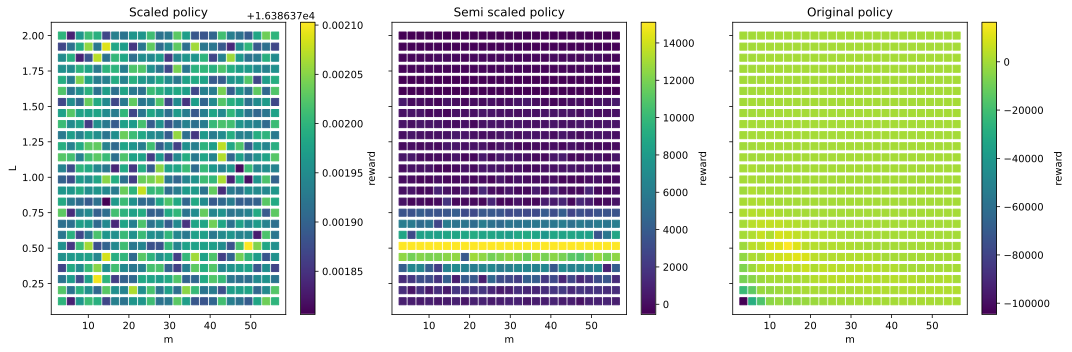

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

similar_scaled_df.plot.scatter("m", "L", c="reward", marker="s", s=50, ax=ax1)
ax1.set_title("Scaled policy")

similar_semi_scaled_df.plot.scatter("m", "L", c="reward", marker="s", s=50, ax=ax2)
ax2.set_title("Semi scaled policy")

similar_naive_df.plot.scatter("m", "L", c="reward", marker="s", s=50, ax=ax3)
ax3.set_title("Original policy")

fig.set_tight_layout(True)

## Quasi similar transfer

### Data generation

In [19]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    change = []
    for sym in quasi_similar_sweep_desc.keys():
        if sym not in base:
            change.append(context.value(sym))

    return context, b1, b2, b3, *change, distance

In [20]:
changed_symbols = []
for sym in quasi_similar_sweep_desc.keys():
    if sym not in base:
        changed_symbols.append(sym)

columns = ["context", base[0], base[1], base[2], *changed_symbols, "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [21]:
all_quasi_similar_contexts = linsweep_change_contexts(original_context, quasi_similar_sweep_desc)

#### Scaled

In [22]:
data_scaled = record_sweep(
    all_quasi_similar_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
quasi_similar_scaled_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.25000,442.422851,-19.801965,2.088740,-21.890704,0
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.40625,442.422851,-19.801965,2.088740,-21.890704,0
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.56250,442.422851,-19.801965,2.088740,-21.890704,0
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.71875,442.422852,-19.801965,2.088740,-21.890704,0
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.87500,442.422852,-19.801965,2.088740,-21.890704,0
...,...,...,...,...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.37500,7073.354672,-1137.302298,3531.187194,-4668.489492,1
621,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.53125,7073.354672,-3340.919706,3293.039170,-6633.958876,1
622,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.68750,7073.354672,-3031.204817,3472.149054,-6503.353872,0
623,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.84375,7073.354672,-393.649204,179.872570,-573.521774,1


#### Semi scaled

In [23]:
data_semi_scaled = record_sweep(
    all_quasi_similar_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
quasi_similar_semi_scaled_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.25000,442.422851,-19.801965,2.088740,-21.890704,0
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.40625,442.422851,-19.801965,2.088740,-21.890704,0
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.56250,442.422851,-19.801965,2.088740,-21.890704,0
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.71875,442.422852,-19.801965,2.088740,-21.890704,0
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.87500,442.422852,-19.801965,2.088740,-21.890704,0
...,...,...,...,...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.37500,7073.354672,-1137.302298,3531.187194,-4668.489492,1
621,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.53125,7073.354672,-3340.919706,3293.039170,-6633.958876,1
622,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.68750,7073.354672,-3031.204817,3472.149054,-6503.353872,0
623,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.84375,7073.354672,-393.649204,179.872570,-573.521774,1


#### Naive

In [24]:
data_naive = record_sweep(
    all_quasi_similar_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
quasi_similar_naive_df = pd.DataFrame(columns=columns, data=data_naive)
quasi_similar_naive_df

,context,m,L,g,taumax,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.25000,442.422851,678.732125,1009.359689,-330.627564,0
1,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.40625,442.422851,754.929936,1112.956149,-358.026212,0
2,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.56250,442.422851,989.257446,1134.816113,-145.558667,1
3,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.71875,442.422852,3728.120982,4118.563292,-390.442310,0
4,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",3.5,0.5,9.81,0.87500,442.422852,77.334438,94.522745,-17.188307,1
...,...,...,...,...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.37500,7073.354672,-214.654026,94.869489,-309.523515,0
621,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.53125,7073.354672,-214.654026,94.869489,-309.523515,0
622,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.68750,7073.354672,-214.654026,94.869489,-309.523515,0
623,"((L, Dimension([0 1 0]), 0.5), (Lh, Dimension(...",56.0,0.5,9.81,3.84375,7073.354672,-214.654026,94.869489,-309.523515,0


### Analysis


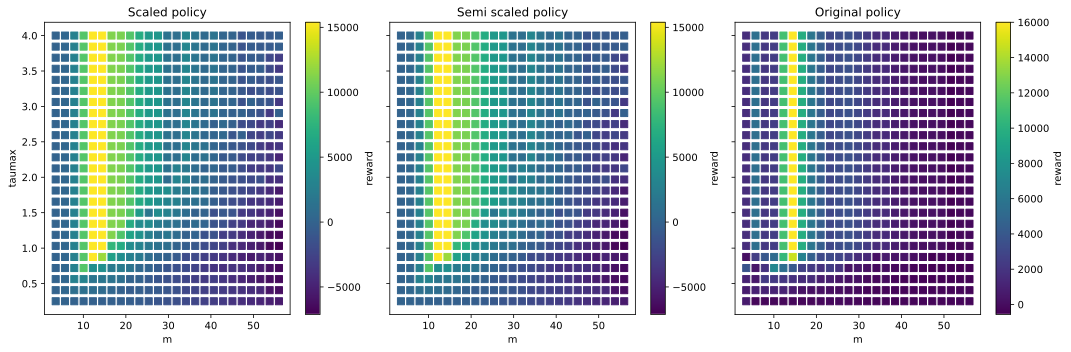

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

quasi_similar_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, ax=ax1)
ax1.set_title("Scaled policy")

quasi_similar_semi_scaled_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, ax=ax2)
ax2.set_title("Semi scaled policy")

quasi_similar_naive_df.plot.scatter("m", "taumax", c="reward", marker="s", s=50, ax=ax3)
ax3.set_title("Original policy")

fig.set_tight_layout(True)

## Non similar transfer

### Data generation

In [26]:
def context_fn(context):
    b1 = context.value(base[0])
    b2 = context.value(base[1])
    b3 = context.value(base[2])
    distance = context.adimensional_distance(original_context, base)

    return context, distance

In [27]:
columns = ["context", "distance", "reward", "fwd_reward", "ctrl_reward", "is_flipped"]

In [28]:
all_non_similar_contexts = []

for _ in range(nb_random_contexts):
    context = original_context.sample_around(lower, upper).change(
        forward_reward_weight=original_context.value("forward_reward_weight"),
        ctrl_cost_weight=original_context.value("ctrl_cost_weight"),
    )
    all_non_similar_contexts.append(context)

#### Scaled

In [29]:
data_scaled = record_sweep(
    all_non_similar_contexts,
    make_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_scaled_df = pd.DataFrame(columns=columns, data=data_scaled)
non_similar_scaled_df

,context,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 26.36407078792446), (...",3.751504e+03,-2.706742e+03,-70.564507,-2.636178e+03,0
1,"((L, Dimension([0 1 0]), 41.71399694635014), (...",7.604524e+05,-5.905975e+05,17840.704772,-6.084382e+05,0
2,"((L, Dimension([0 1 0]), 47.41564248314194), (...",1.423113e+06,-1.248094e+06,-38.977473,-1.248055e+06,0
3,"((L, Dimension([0 1 0]), 38.79727656762852), (...",2.221209e+05,-1.872419e+05,-652.498761,-1.865894e+05,0
4,"((L, Dimension([0 1 0]), 16.836268889739415), ...",2.318138e+03,-2.102441e+03,-10.877217,-2.091564e+03,0
...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 4.080491587697978), (...",2.684991e+02,-3.669398e+02,372.679997,-7.396198e+02,1
621,"((L, Dimension([0 1 0]), 37.99543513835758), (...",1.447591e+05,-1.364613e+05,374.806596,-1.368361e+05,0
622,"((L, Dimension([0 1 0]), 9.545072357613279), (...",1.147712e+04,4.036375e+03,8034.730737,-3.998356e+03,1
623,"((L, Dimension([0 1 0]), 33.409858114075995), ...",7.635296e+05,-5.637242e+05,14.224711,-5.637384e+05,0


#### Semi scaled

In [30]:
data_semi_scaled = record_sweep(
    all_non_similar_contexts,
    make_semi_scaled_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_semi_scaled_df = pd.DataFrame(columns=columns, data=data_semi_scaled)
non_similar_semi_scaled_df

,context,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 26.36407078792446), (...",3.751504e+03,-5.444413e+03,-86.837046,-5.357576e+03,0
1,"((L, Dimension([0 1 0]), 41.71399694635014), (...",7.604524e+05,-9.669610e+05,-93.058272,-9.668680e+05,0
2,"((L, Dimension([0 1 0]), 47.41564248314194), (...",1.423113e+06,-1.807712e+06,2.626555,-1.807715e+06,0
3,"((L, Dimension([0 1 0]), 38.79727656762852), (...",2.221209e+05,-2.827720e+05,-70.867741,-2.827011e+05,0
4,"((L, Dimension([0 1 0]), 16.836268889739415), ...",2.318138e+03,-3.514531e+03,-12.132445,-3.502399e+03,0
...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 4.080491587697978), (...",2.684991e+02,-3.763220e+02,363.547747,-7.398697e+02,1
621,"((L, Dimension([0 1 0]), 37.99543513835758), (...",1.447591e+05,-1.847416e+05,-70.939849,-1.846707e+05,0
622,"((L, Dimension([0 1 0]), 9.545072357613279), (...",1.147712e+04,-7.459258e+03,6703.641611,-1.416290e+04,1
623,"((L, Dimension([0 1 0]), 33.409858114075995), ...",7.635296e+05,-9.713947e+05,6.045179,-9.714008e+05,0


#### Naive

In [31]:
data_naive = record_sweep(
    all_non_similar_contexts,
    make_naive_policy,
    make_env,
    context_fn=context_fn,
    ep_fn=ep_fn_extract_reward,
    ep_reduce_fn=ep_reduce_fn_total_reward,
    fuse_fn=fuse_fn
)
non_similar_naive_df = pd.DataFrame(columns=columns, data=data_naive)
non_similar_naive_df

,context,distance,reward,fwd_reward,ctrl_reward,is_flipped
0,"((L, Dimension([0 1 0]), 26.36407078792446), (...",3.751504e+03,-670.138863,-71.460808,-598.678055,0
1,"((L, Dimension([0 1 0]), 41.71399694635014), (...",7.604524e+05,-719.533554,-120.519662,-599.013892,0
2,"((L, Dimension([0 1 0]), 47.41564248314194), (...",1.423113e+06,-611.535745,-12.734916,-598.800828,0
3,"((L, Dimension([0 1 0]), 38.79727656762852), (...",2.221209e+05,-611.473855,-12.141511,-599.332344,0
4,"((L, Dimension([0 1 0]), 16.836268889739415), ...",2.318138e+03,-604.339774,-12.094275,-592.245499,0
...,...,...,...,...,...,...
620,"((L, Dimension([0 1 0]), 4.080491587697978), (...",2.684991e+02,-234.506918,365.038258,-599.545176,1
621,"((L, Dimension([0 1 0]), 37.99543513835758), (...",1.447591e+05,-626.547202,-27.013508,-599.533694,0
622,"((L, Dimension([0 1 0]), 9.545072357613279), (...",1.147712e+04,5633.893472,5833.002139,-199.108667,1
623,"((L, Dimension([0 1 0]), 33.409858114075995), ...",7.635296e+05,-592.983353,6.501384,-599.484736,0


### Analysis

<Axes: xlabel='distance', ylabel='fwd_reward'>

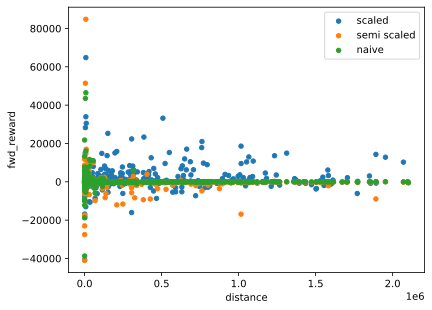

In [32]:
fig, ax = plt.subplots()
non_similar_scaled_df.plot.scatter("distance", "fwd_reward", label="scaled", c="tab:blue", ax=ax)
non_similar_semi_scaled_df.plot.scatter("distance", "fwd_reward", label="semi scaled", c="tab:orange", ax=ax)
non_similar_naive_df.plot.scatter("distance", "fwd_reward", label="naive", c="tab:green", ax=ax)